In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import cv2, os

In [2]:
%cd ..

/home/suetin/Projects/VSCode/UltrasoundCardiacReconstruction/HeartReconstruction


/home/suetin/Projects/VSCode/UltrasoundCardiacReconstruction/.venv/lib/python3.10/site-packages/IPython/core/magics/osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [3]:
img_path = 'data/train/train/images/0001.png'
mask_path = 'data/train/train/masks/0001.png'

img = cv2.imread(img_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
msk = cv2.imread(mask_path)
msk = cv2.cvtColor(msk, cv2.COLOR_BGR2RGB)

img.shape

(512, 512, 3)

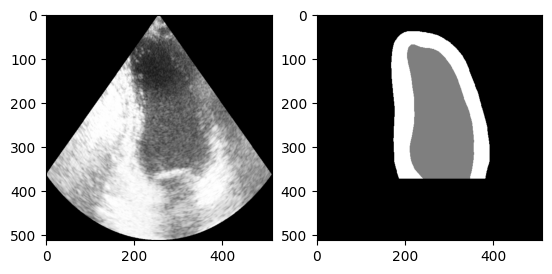

In [4]:
plt.subplot(121)
plt.imshow(img);
plt.subplot(122)
plt.imshow(msk);

In [5]:
np.unique(msk)

array([  0, 127, 255], dtype=uint8)

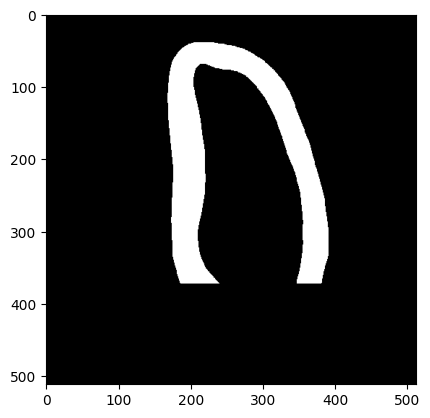

In [33]:
new_msk = np.where(msk == 255, 255, 0)
plt.imshow(new_msk)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].


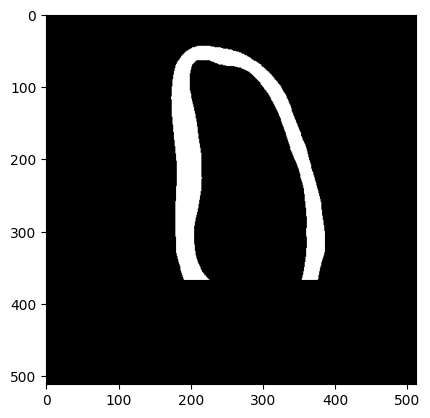

In [34]:
plt.imshow(cv2.erode(new_msk.astype(float), np.ones((11, 11))))